In [1]:
import os
import numpy as np
from datetime import datetime as dt
import datetime
from datetime import timedelta
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sms
import csv
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install tsfel >/dev/null 2>&1
from sys import platform
if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1
else:
    !pip install wget >/dev/null 2>&1
    import wget
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip')
import tsfel

In [2]:
dates = ['16.02','18.02','26.04','28.04']
list_dfs = []
max_length = 0
for i in range(len(dates)):
    date = dates[i]
    orig_folder = 'C:/Users/Anni/CS/_BA/ReLkat/data/data_csv/'+date+"/"
    data_df = pd.read_csv(os.path.join(orig_folder,date+"_total.csv"),index_col = 0)
    list_dfs.append(data_df)
    print(date," loading data from ", date, "with number of datapoints: ",data_df.shape)
    if (data_df.shape[1]>max_length):
        max_length = data_df.shape[1]
base_cols = list(data_df.columns[:7])
print("_________________________________________________________________________________")
print("padding all energy time series to length: ",str(max_length-len(base_cols)))
for i in range(len(dates)):
    data_df = list_dfs[i]    
    extra_cols = max_length - (data_df.shape[1])       
    cols =  base_cols + ["_"+str(i) for i in data_df.columns[7:]]    
    data_df.columns = cols
    if(extra_cols>0):        
        data_ar = np.pad(np.array(data_df), ((0, 0), (0, extra_cols)), 'constant', constant_values=(0))
        print(data_ar.shape)        
        df = pd.DataFrame(data_ar)
        cols = base_cols + ["_"+str(i) for i in range(0,max_length-len(base_cols))] 
        df.columns = cols
        list_dfs[i] = df

16.02  loading data from  16.02 with number of datapoints:  (6, 366)
18.02  loading data from  18.02 with number of datapoints:  (27, 326)
26.04  loading data from  26.04 with number of datapoints:  (27, 340)
28.04  loading data from  28.04 with number of datapoints:  (84, 360)
_________________________________________________________________________________
padding all energy time series to length:  359
(27, 366)
(27, 366)
(84, 366)


In [3]:
# SET INPUT PARAMETERS
# 1) Set energy_prev to True in order to include previous values of control parameters
# 2) If energy_prev is True, select method for aggregation ('trapz','3_par_sum','PCA','TSFEL')
# 3) Set control_prev to True in order to include previous values of control parameters

# Format and scale cycle time
# Scale energy values
# Normalize values
# Shift energy values and keep current value as target
# Replace missing values for previous values with maximum values of column

energy_prev = True
energy_prev_agg = 'PCA'
control_prev = True
extra_feat = False
feature = 'DF'
feat_agg = 'PCA'

for i in range(len(list_dfs)):
    df = list_dfs[i]
    
    df['cycle_time'] = (df['cycle_time']).apply(lambda x: str(x)[10:22])
    df['cycle_time'] =  (df['cycle_time']).apply(lambda x: datetime.datetime.strptime(x,'%M:%S.%f'))
    df['cycle_time'] = (df['cycle_time']).apply(lambda x:datetime.timedelta(minutes=x.minute,\
                                        seconds=x.second,microseconds=x.microsecond).total_seconds())
    df['cycle_time_prev'] = df['cycle_time'].shift(periods=1)
    df.loc[0,'cycle_time_prev'] = df['cycle_time_prev'].max()
    
    if (energy_prev==True):
        df[df.columns[7:-1]] = df[df.columns[7:-1]].shift(periods=1)               
        date = dates[i]
        energy_folder = 'C:/Users/Anni/CS/_BA/ReLkat/data/Versuche/Versuche '+date+'/'
        start_time_str = df['start_time'][0][:19]
        start_time = datetime.datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S')
        print(start_time)
        ts = []

        with open(os.path.join(energy_folder,'energy_'+date+'.csv'),encoding="utf-8") as csvfile:
            print("opening ",os.path.join(energy_folder,'energy_'+date+'.csv' ))
            reader = csv.reader(csvfile, delimiter=';', quotechar='/')
            next(reader)
            next(reader)   
            for line in reader:        

                if start_time + timedelta(seconds = -np.ceil(df['cycle_time_prev'][0]))<= np.datetime64(datetime.datetime.strptime(line[0], '%d.%m.%Y %H:%M:%S')) < start_time:
                    ts.append((float(line[2].replace(',', '.'))))
                    
        extra_cols = max_length-len(base_cols)-len(ts)
        pad_ts = np.pad(np.array(ts), ((0), (extra_cols)), 'constant', constant_values=(0))
        df.loc[0,7:max_length] = pad_ts    
        df['energy_total_prev'] = np.trapz(np.array(df)[:,7:max_length])
 
    if (control_prev==True):
        df['Hyd_prev'] = df['Hyd'].shift(periods=1)
        df['KSS_prev'] = df['KSS'].shift(periods=1)
        df['KSS_HD_prev'] = df['KSS_HD'].shift(periods=1)
        for col in df.columns[-3:]:
            df.loc[0,col] = df[col].max()
        
    list_dfs[i] = df
    
df = pd.concat(list_dfs, axis =0, ignore_index=True)

2021-02-16 12:11:28
opening  C:/Users/Anni/CS/_BA/ReLkat/data/Versuche/Versuche 16.02/energy_16.02.csv


<ipython-input-3-cd48d0170b2d>:50: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[0,7:max_length] = pad_ts


2021-02-18 14:11:51
opening  C:/Users/Anni/CS/_BA/ReLkat/data/Versuche/Versuche 18.02/energy_18.02.csv
2021-04-26 14:16:16
opening  C:/Users/Anni/CS/_BA/ReLkat/data/Versuche/Versuche 26.04/energy_26.04.csv
2021-04-28 10:17:49
opening  C:/Users/Anni/CS/_BA/ReLkat/data/Versuche/Versuche 28.04/energy_28.04.csv


In [4]:
def create_feat_array(ar,fs,window_size):  

    cfg_file_temp = tsfel.get_features_by_domain()                                         
    ar_feat = tsfel.time_series_features_extractor(cfg_file_temp, ar,fs=fs, window_size=window_size)
    corr_features = tsfel.correlated_features(ar_feat)
    ar_feat.drop(corr_features, axis=1, inplace=True)
    selector = VarianceThreshold()
    ar_feat = selector.fit_transform(ar_feat)
    print(ar_feat.shape) 
    scaler = preprocessing.StandardScaler()
    ar_feat_norm = scaler.fit_transform(ar_feat)
    print(ar_feat_norm.shape)

    return ar_feat_norm

In [5]:
pd.set_option('display.max_rows', 150)

mms = MinMaxScaler()
if(energy_prev == True):
    if(energy_prev_agg == 'PCA'):
        n_com = 3
        pca = decomposition.PCA(n_components=n_com)
        en_PCA_3 = pca.fit_transform(np.array(df)[:,7:366])  
        df['_energy_PCA_c1_prev'] = en_PCA_3[:,0]
        df['_energy_PCA_c2_prev'] = en_PCA_3[:,1]
        df['_energy_PCA_c3_prev'] = en_PCA_3[:,2] 
        if (control_prev==True):
            df = df[['Hyd','KSS','KSS_HD','_energy_PCA_c1_prev','_energy_PCA_c2_prev','_energy_PCA_c3_prev','cycle_time_prev','Hyd_prev','KSS_prev','KSS_HD_prev','energy_total','cycle_time']]
        else:           
            df = df[['Hyd','KSS','KSS_HD','_energy_PCA_c1_prev','_energy_PCA_c2_prev','_energy_PCA_c3_prev','cycle_time_prev','energy_total','cycle_time']]
        df[['_energy_PCA_c1_prev']] = mms.fit_transform(df[['_energy_PCA_c1_prev']])
        df[['_energy_PCA_c2_prev']] = mms.fit_transform(df[['_energy_PCA_c2_prev']])
        df[['_energy_PCA_c3_prev']] = mms.fit_transform(df[['_energy_PCA_c3_prev']])
       
    elif(energy_prev_agg == '3_par_sum'):            
        #Divide energy total into three equal parts
        df['energy_1_prev'] = (df[df.columns[7:126]]).sum(axis =1)
        df['energy_2_prev'] = (df[df.columns[126:245]]).sum(axis =1)
        df['energy_3_prev'] = (df[df.columns[245:365]]).sum(axis =1)
        
        df[['energy_1_prev']] = mms.fit_transform(df[['energy_1_prev']]) 
        df[['energy_2_prev']] = mms.fit_transform(df[['energy_2_prev']]) 
        df[['energy_3_prev']] = mms.fit_transform(df[['energy_3_prev']])
        
        if (control_prev==True):
            df = df[['Hyd','KSS','KSS_HD','energy_1_prev','energy_2_prev','energy_3_prev','cycle_time_prev','Hyd_prev','KSS_prev','KSS_HD_prev','energy_total','cycle_time']]
        else:        
            df = df[['Hyd','KSS','KSS_HD','energy_1_prev','energy_2_prev','energy_3_prev','cycle_time_prev','energy_total','cycle_time']]
        
    elif(energy_prev_agg == 'TSFEL'):  
        rows, cols = df[df.columns[7:366]].shape[0],df[df.columns[7:366]].shape[1]
        ar = np.array(df[df.columns[7:366]]).reshape(cols*rows,1)
        if (control_prev==True):
            df = df[['Hyd','KSS','KSS_HD','cycle_time_prev','Hyd_prev','KSS_prev','KSS_HD_prev','energy_total','cycle_time']]
        else:        
            df = df[['Hyd','KSS','KSS_HD','cycle_time_prev','energy_total','cycle_time']]
                    
        ar_en_total = create_feat_array(ar_en,1,359)
        df = pd.concat([df,pd.DataFrame(tsfel_en_total)],axis=1)        
    
    elif(energy_prev_agg == 'trapz'):
        
        if (control_prev==True):
            df = df[['Hyd','KSS','KSS_HD','energy_total_prev','cycle_time_prev','Hyd_prev','KSS_prev','KSS_HD_prev','energy_total','cycle_time']]
        else:
            df = df[['Hyd','KSS','KSS_HD','energy_total_prev','cycle_time_prev','energy_total','cycle_time']]
        df[['energy_total_prev']] = mms.fit_transform(df[['energy_total_prev']]) 
else:
    df = df[['Hyd','KSS','KSS_HD','cycle_time_prev','energy_total','cycle_time']]    

df[['cycle_time_prev']] = mms.fit_transform(df[['cycle_time_prev']]) 

df['Hyd'] = np.around((df['Hyd']/27648).astype(np.double),2)
df['KSS'] = (df['KSS']-20)/50
df['KSS_HD'] = (df['KSS_HD']-5)/50
if (control_prev==True):
    df['Hyd_prev'] = np.around((df['Hyd_prev']/27648).astype(np.double),2)
    df['KSS_prev'] = (df['KSS_prev']-20)/50
    df['KSS_HD_prev'] = (df['KSS_HD_prev']-5)/50
if (extra_feat==True):
    feat=np.load('C:/Users/Anni/CS/_BA/ReLkat/data/total/MD_feature_arrays/ar_PCA_DF_KSS_HD_3.npy')

In [702]:
print(pca.explained_variance_ratio_)

[0.36317627 0.1812209  0.09350485]


In [648]:
DF_KSS_HD = np.load('C:/Users/Anni/CS/_BA/ReLkat/data/total/MD_feature_arrays/DF_KSS_HD_feat_norm.npy')
DF_KSS_ND = np.load('C:/Users/Anni/CS/_BA/ReLkat/data/total/MD_feature_arrays/DF_KSS_ND_feat_norm.npy')
print(DF_KSS_HD.shape)
print(DF_KSS_ND.shape)

(144, 29)
(144, 15)


In [680]:
DF_KSS_HD = np.load('C:/Users/Anni/CS/_BA/ReLkat/data/total/MD_feature_arrays/ar_PCA_DF_KSS_HD_3.npy')
DF_KSS_ND = np.load('C:/Users/Anni/CS/_BA/ReLkat/data/total/MD_feature_arrays/ar_PCA_DF_KSS_ND_3.npy')
print(DF_KSS_HD.shape)
print(DF_KSS_ND.shape)

(144, 3)
(144, 3)


In [681]:
DF_KSS_ars = [DF_KSS_HD, DF_KSS_ND] 
for i in range(2):
    df = pd.concat([df,pd.DataFrame(DF_KSS_ars[i])],axis=1)
print(df.shape)

(144, 16)


In [6]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 150)
print(df.shape)
data_df = df
data_df.head()

(144, 12)


,Hyd,KSS,KSS_HD,_energy_PCA_c1_prev,_energy_PCA_c2_prev,_energy_PCA_c3_prev,cycle_time_prev,Hyd_prev,KSS_prev,KSS_HD_prev,energy_total,cycle_time
0,0.95,0.54,0.82,0.878209,0.019983,0.324334,1.000000,0.95,0.54,0.82,3226.45026,356.434843
1,0.85,0.42,0.66,0.992507,0.044631,0.999801,0.996593,0.95,0.54,0.82,3131.310764,352.370635
2,0.80,0.36,0.58,0.993032,0.068985,0.964535,0.947989,0.85,0.42,0.66,2783.481727,316.295091
3,0.75,0.3,0.5,0.447904,0.128419,0.037228,0.516553,0.80,0.36,0.58,2865.966346,321.714814
4,0.70,0.24,0.42,0.730442,0.067683,0.049250,0.581369,0.75,0.3,0.5,2934.805754,356.719699


In [10]:
data_df[data_df['energy_total']==data_df['energy_total'].min()]
data_df[data_df['Hyd']==data_df['Hyd'].min()]

,Hyd,KSS,KSS_HD,_energy_PCA_c1_prev,_energy_PCA_c2_prev,_energy_PCA_c3_prev,cycle_time_prev,Hyd_prev,KSS_prev,KSS_HD_prev,energy_total,cycle_time
23,0.5,0.0,0.0,0.159138,0.213621,0.460321,0.370112,0.55,0.06,0.18,2651.937596,304.129250
24,0.5,0.0,0.26,0.149429,0.209324,0.425130,0.371059,0.50,0.0,0.0,2459.783585,304.240979
25,0.5,0.0,0.24,0.212558,0.272294,0.443498,0.372395,0.50,0.0,0.26,2525.5096,304.220425
26,0.5,0.0,0.2,0.160264,0.255093,0.477896,0.372149,0.50,0.0,0.24,2608.709555,304.330531
27,0.5,0.0,0.22,0.125084,0.213466,0.447490,0.373466,0.50,0.0,0.2,2498.936317,304.195394
32,0.5,0.6,0.9,0.112075,0.110893,0.494891,0.369990,0.75,0.6,0.9,2923.434574,304.350491
55,0.5,0.0,0.2,0.107345,0.196676,0.480897,0.368969,0.75,0.3,0.46,2701.618668,304.189761
56,0.5,0.0,0.2,0.128929,0.177583,0.482222,0.371783,0.50,0.0,0.2,2479.725966,304.720038
57,0.5,0.0,0.2,0.162415,0.267159,0.472257,0.378124,0.50,0.0,0.2,2538.19001,303.930497
58,0.5,0.0,0.2,0.168338,0.253703,0.479716,0.368682,0.50,0.0,0.2,2514.320034,304.894828


In [683]:
feature = 'en-trapz_contr_pars_DF_PCA'
aggregation_method = ''
filename = "df_"+feature+"_"+aggregation_method
dest_folder = 'C:/Users/Anni/CS/_BA/Relkat/data/total/final/'
data_df.to_csv(os.path.join(dest_folder,filename)+".csv")
print(os.path.join(dest_folder,filename)+".csv")

C:/Users/Anni/CS/_BA/Relkat/data/total/final/df_en-trapz_contr_pars_DF_PCA_.csv


In [684]:
X = data_df.drop(['energy_total','cycle_time'],axis=1)
y = data_df[['energy_total','cycle_time']]

In [685]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20, random_state=42)

In [686]:
print(X_train.shape[1])
print(y_train.shape[1])

14
2


In [688]:
feature_importances_ran_forest = np.zeros([X_train.shape[1],y_train.shape[1]])

for i in range(2):           
    forest_reg = RandomForestRegressor(n_estimators = 30,random_state=42,criterion='mse',
                                       bootstrap=True, oob_score=True, n_jobs = -1)
    forest_reg.fit(X_train,y_train[:,i])    
    feature_importances_ran_forest[:,i] = forest_reg.feature_importances_  
    scores = cross_val_score(forest_reg, X.values, y.values[:,i], scoring='neg_mean_squared_error',cv=10)  
    scores = (np.sqrt(-scores))
    if (i==0):
        print("Predicting total energy:")
        print("std error: ",scores.std())
        print("mean RMSE: ",scores.mean()) #mean RMSE
        predictions = forest_reg.predict(X_test)
        
        RAE = (np.sqrt(((np.square(y_test[:,i]-predictions)).sum())/y_test[i].mean()))*100
        print("RAE on test set in %: ",RAE) 
        
        
        RMSE = np.sqrt(((np.square(y_test[:,i]-predictions)).sum())/y_test[i].shape[0])
        print("RMSE on test set: ",RMSE) 
        score = forest_reg.score(X_test,y_test[:,i])
        print("score: ",score)
        
        print(cross_val_score(forest_reg, X.values, y.values[:,i],cv=10))
        
    if (i==1):
        print("--------------------------------------------------------------------------")
        print("Predicting total cycle time:")
        print("std error: ",scores.std())
        print("mean RMSE: ",scores.mean()) #mean RMSE
        predictions = forest_reg.predict(X_test)
        
        RAE = (np.sqrt(((np.square(y_test[:,i]-predictions)).sum())/y_test[i].mean()))*100
        print("RAE on test set in %: ",RAE) 
        
        RMSE = np.sqrt(((np.square(y_test[:,i]-predictions)).sum())/y_test[i].shape[0])
        print("RMSE on test set: ",RMSE) 
        
        score = forest_reg.score(X_test,y_test[:,i])
        print("score: ",score)
        
        print(cross_val_score(forest_reg, X.values, y.values[:,i],cv=10))

Predicting total energy:
std error:  45.84162912417439
mean RMSE:  84.46692181331713
RAE on test set in %:  885.3967380958156
RMSE on test set:  239.41268622565025
score:  0.7291456805508747
[-2.19870985  0.32667171  0.03118976  0.06528554  0.2830652   0.47562214
  0.45235003  0.43652508 -0.29802151  0.36670552]
--------------------------------------------------------------------------
Predicting total cycle time:
std error:  8.881835161315404
mean RMSE:  8.493702458600179
RAE on test set in %:  113.10290424686247
RMSE on test set:  31.8236912050046
score:  0.2817365836862894
[-1.11531701e+00 -8.02224187e+02  1.29995789e-01 -6.23213752e+00
 -1.01952076e+00 -4.34848661e+01 -6.50947755e+01 -1.23108461e+01
 -8.53894384e-02 -5.12594428e+01]


Feature ranking:
1. KSS_HD (0.273063)
2. 1 (0.077865)
3. 214 (0.053226)
4. 85 (0.043282)
5. 125 (0.037583)
6. Hyd (0.019680)
7. 112 (0.015931)
8. 0 (0.015852)
9. KSS (0.014190)
10. 74 (0.014115)
11. 151 (0.011997)
12. 160 (0.011680)
13. 99 (0.010133)
14. 220 (0.009542)
15. cycle_time_prev (0.009339)
16. 100 (0.008913)
17. 89 (0.008467)
18. 128 (0.007950)
19. 120 (0.007396)
20. 223 (0.007368)
21. 124 (0.007243)
22. 138 (0.006355)
23. 73 (0.006262)
24. 121 (0.006134)
25. 157 (0.005806)
26. 165 (0.005672)
27. 5 (0.005496)
28. 148 (0.005338)
29. 132 (0.005179)
30. 41 (0.005112)
31. 131 (0.005056)
32. 228 (0.004996)
33. 14 (0.004701)
34. 30 (0.004688)
35. 103 (0.004676)
36. 209 (0.004350)
37. 188 (0.004257)
38. 219 (0.004210)
39. 19 (0.004046)
40. 149 (0.004035)
41. 208 (0.003943)
42. 123 (0.003884)
43. 33 (0.003788)
44. 22 (0.003682)
45. 101 (0.003664)
46. 156 (0.003610)
47. 6 (0.003532)
48. 172 (0.003523)
49. 137 (0.003383)
50. 199 (0.003260)
51. 44 (0.003253)
52. 200 (0.003228)
53. 55 (0

(-1.0, 237.0)

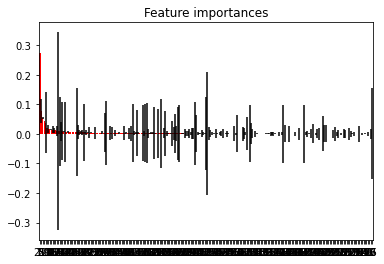

In [608]:
h = 0
std = np.std([tree.feature_importances_ for tree in forest_reg.estimators_],
             axis=0)
indices = np.argsort(feature_importances_ran_forest[:,h])[::-1]

# Print the feature ranking
print("Feature ranking:")
summe = 0
for f in range(X_train.shape[1]):
    summe = summe + (feature_importances_ran_forest[:,h])[indices[f]]
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]],(feature_importances_ran_forest[:,h])[indices[f]]))
print(summe)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), (feature_importances_ran_forest[:,h])[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])

In [67]:
feature_importances_ran_forest

array([[0.11683688, 0.01428143],
       [0.04093932, 0.03190118],
       [0.46710816, 0.04088512],
       [0.0805484 , 0.60919505],
       [0.09688384, 0.05472156],
       [0.08163991, 0.20899244],
       [0.1160435 , 0.04002321]])

In [696]:
feature_importances_linear = np.zeros([X_train.shape[1],y_train.shape[1]])

for i in range(2):

    lasso = linear_model.Lasso(alpha=0.1, fit_intercept=False, random_state=1, max_iter=50000)    
    lasso.fit(X_train,y_train[:,i])
    scores_ls = cross_val_score(lasso, X.values, y.values[:,i], scoring='neg_mean_squared_error',cv=10)                       
    scores_ = (np.sqrt(-scores_ls))    
    feature_importances_linear[:,i] = lasso.coef_    

    score = lasso.score(X_test,y_test[:,i])
    predictions = lasso.predict(X_test)
    RMSE = np.sqrt(((np.square(y_test[:,i]-predictions)).sum())/y_test[i].shape[0])
    
    RAE = (np.sqrt(((np.square(y_test[:,i]-predictions)).sum())/y_test[i].mean()))*100
          
    if(i==0):
        print("predicting total energy:")
        print("training:")
        print("std error: ",scores_.std())
        print("mean RMSE on train set: ",scores_.mean())
        print("test")
        print("RMSE on test set: ",RMSE) 
        print("RAE on test set in %: ",RAE)  
        print("test score: ",score)
        
        print(cross_val_score(lasso, X.values, y.values[:,i],cv=10))
        
    if(i==1):
        print("-------------------------------------------------------------------")
        print("predicting cycle time:")
        print("training:")
        print("std error: ",scores_.std())
        print("mean RMSE on train set: ",scores_.mean())
        print("test")
        print("RMSE on test set: ",RMSE)   
        print("RAE on test set in %: ",RAE)  
        print("test score: ",score)
        
        print(cross_val_score(lasso, X.values, y.values[:,i],cv=10))

predicting total energy:
training:
std error:  188.1350107183398
mean RMSE on train set:  248.63297683203433
test
RMSE on test set:  657.4895204320707
RAE on test set in %:  2431.5297819016246
test score:  -1.0427683344933572
[-16.45852387  -1.72046254 -88.2479306   -0.52431721  -3.54827856
  -3.74114631  -4.97546966  -4.90746802  -3.25558223  -2.879803  ]
-------------------------------------------------------------------
predicting cycle time:
training:
std error:  25.020582510461974
mean RMSE on train set:  31.15059903442792
test
RMSE on test set:  72.28556945503072
RAE on test set in %:  256.9063339584112
test score:  -2.705833106235021
[-6.70760912e+00 -4.26673004e+03 -1.03382775e+02 -3.28316696e+02
 -1.07752088e+01 -4.00173105e+03 -3.64535349e+03 -6.23175320e+03
 -2.90837740e+00 -9.56367072e+02]


In [207]:
feature_importances_linear

array([[ 0.        ,  0.        ],
       [ 0.        , -0.        ],
       [ 0.06861498,  0.        ],
       [ 0.0086256 , -0.        ],
       [ 0.08315615,  0.        ],
       [ 0.13503779,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.03451031],
       [ 0.        , -0.        ],
       [-0.        , -0.        ]])

In [208]:
features = X.columns[:12]
def pretty_print_linear(coefs, names = None, sort = False):
    #if names == None:
        #names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))[0:15]
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)
 
print ("Linear model:"), pretty_print_linear(feature_importances_linear[:,0],names=features,sort=True)

Linear model:


(None,
 '0.135 * KSS_HD_prev + 0.083 * KSS_prev + 0.069 * KSS_HD + 0.009 * Hyd_prev + 0.0 * Hyd + 0.0 * KSS + 0.0 * cycle_time_prev + 0.0 * _energy_PCA_c1_prev + 0.0 * _energy_PCA_c2_prev + -0.0 * _energy_PCA_c3_prev')

In [209]:
pd.set_option('display.max_rows', 134)
corr_matrix = data_df.corr()
sorted_corr_en = corr_matrix["energy_total"].sort_values(ascending=False)
sorted_corr_en

energy_total           1.000000
Hyd_prev               0.654586
Hyd                    0.545417
cycle_time             0.480637
_energy_PCA_c1_prev    0.348695
cycle_time_prev        0.343174
_energy_PCA_c2_prev    0.320135
_energy_PCA_c3_prev   -0.282732
Name: energy_total, dtype: float64

In [210]:
pd.set_option('display.max_rows', 134)
corr_matrix = data_df.corr()
sorted_corr_tz = corr_matrix["cycle_time"].sort_values(ascending=False)
sorted_corr_tz

cycle_time             1.000000
cycle_time_prev        0.540529
_energy_PCA_c1_prev    0.531738
energy_total           0.480637
_energy_PCA_c2_prev    0.147204
Hyd_prev               0.069896
_energy_PCA_c3_prev    0.020037
Hyd                    0.008541
Name: cycle_time, dtype: float64

In [211]:
corr_matrix

,Hyd,energy_total,cycle_time,Hyd_prev,cycle_time_prev,_energy_PCA_c1_prev,_energy_PCA_c2_prev,_energy_PCA_c3_prev
Hyd,1.000000,0.545417,0.008541,0.698230,0.075054,0.131880,0.261694,-0.300754
energy_total,0.545417,1.000000,0.480637,0.654586,0.343174,0.348695,0.320135,-0.282732
cycle_time,0.008541,0.480637,1.000000,0.069896,0.540529,0.531738,0.147204,0.020037
Hyd_prev,0.698230,0.654586,0.069896,1.000000,0.051634,0.109488,0.312713,-0.375174
cycle_time_prev,0.075054,0.343174,0.540529,0.051634,1.000000,0.916358,-0.061601,0.003056
_energy_PCA_c1_prev,0.131880,0.348695,0.531738,0.109488,0.916358,1.000000,0.123307,0.114857
_energy_PCA_c2_prev,0.261694,0.320135,0.147204,0.312713,-0.061601,0.123307,1.000000,0.115502
_energy_PCA_c3_prev,-0.300754,-0.282732,0.020037,-0.375174,0.003056,0.114857,0.115502,1.000000
